# Northern California Weather Analysis

This is a report on the historical analysis of weather patterns in an area that approximately overlaps the area of the state of California.

The data we will use here comes from [NOAA](https://www.ncdc.noaa.gov/). Specifically, it was downloaded from This [FTP site](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/).

We focused on six measurements:
* **TMIN, TMAX:** the daily minimum and maximum temperature.
* **TOBS:** The average temperature for each day.
* **PRCP:** Daily Percipitation (in mm)
* **SNOW:** Daily snowfall (in mm)
* **SNWD:** The depth of accumulated snow.


## Sanity-check: comparison with outside sources

<p>We start by comparing some of the general statistics with graphs that we obtained from a site called <a href="http://www.usclimatedata.com/climate/california/united-states/3174" target="_blank">US Climate Data</a> The graph below shows the daily minimum and maximum temperatures for each month, as well as the total precipitation for each month.</p>

<p>&nbsp;</p>

<p><img alt="Climate_Sacremento_-_California_and_Weather_averages_Sacremento" src="c_figures/Climate_Sacremento_-_California_and_Weather_averages_Sacremento.jpg" /></p>

<p>&nbsp;</p>

<p>We see that the min and max daily&nbsp;temperature agree with the ones we got from our data, once we translate Fahrenheit to Centigrade.</p>

<p>&nbsp;</p>

<p><img alt="TMIN,TMAX.png" src="r_figures/TMIN,TMAX.png" style="height:300px; width:800px" /></p>

<p>To compare the precipitation&nbsp;we need to translate millimeter/day to inches/month. According to our analysis the average rainfall is 3.00 mm/day which translates to about 3.55 Inches&nbsp;per month. According to US-Climate-Data the average rainfall is closer to 4 inch per month. However, there is clear agreement that average precipitation&nbsp;is close to a constant throughout the year</p>

<p>&nbsp;<img alt="PRCP.png" src="r_figures/PRCP.png" style="height:450px; width:600px" /></p>



<p><b>Top 10 weather stations</b> and numbers of records for each of the top 10 station: </p>
USC00040693    526 <br />
USC00044997    511 <br />
USC00044500    481 <br />
USC00045032    455 <br />
USC00048560    420 <br />
USW00023258    406 <br />
USC00046144    377 <br />
USW00023272    377 <br />
USC00047880    344 <br />
USC00045915    342 </p>
Name: station, dtype: int64
<p> <b>Top 10 weather stations<b> provide 34.04 % of all records  </p>

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
#file_index='SSSBSSSB'
file_index='SSSBSSSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12452
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     1|[00 53 40 52 A0 5...|1995.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     1|[08 59 08 59 B0 5...|1996.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     0|[E0 58 B0 58 28 5...|1997.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     0|[50 57 F0 56 A0 5...|1998.0|SSSBSSSB|
|    442.0| 37.9442|-122.1178|       TMAX|USR0000CBRI|     0|[28 58 80 58 50 5...|1999.0|SSSBSSSB|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
# Determine #
print 'There are %d of stations in my dataset' %df.select("station").count()
#df.groupby('station').agg({'station': 'count'}).show()
df_panda = df.toPandas()
df_panda['station'].value_counts()[0:10]

There are 12452 of stations in my dataset


USC00040693    526
USC00044997    511
USC00044500    481
USC00045032    455
USC00048560    420
USW00023258    406
USC00046144    377
USW00023272    377
USC00047880    344
USC00045915    342
Name: station, dtype: int64

In [32]:
df_SNWD = df_panda[df_panda['measurement']=='SNWD']
df_SNWD['station'].value_counts()
station_id_max_prcp = df_SNWD['station'].value_counts().index[0]
ado = (df_panda.loc[df_panda['station'] == station_id_max_prcp])
ado.loc[ado['measurement'] == 'SNWD']

,elevation,latitude,longitude,measurement,station,undefs,vector,year,label
10679,94.5,37.8744,-122.2606,SNWD,USC00040693,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1919.0,SSSBSSSB
10680,94.5,37.8744,-122.2606,SNWD,USC00040693,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1920.0,SSSBSSSB
10681,94.5,37.8744,-122.2606,SNWD,USC00040693,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1921.0,SSSBSSSB
10682,94.5,37.8744,-122.2606,SNWD,USC00040693,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1922.0,SSSBSSSB
10683,94.5,37.8744,-122.2606,SNWD,USC00040693,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1923.0,SSSBSSSB
10684,94.5,37.8744,-122.2606,SNWD,USC00040693,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1924.0,SSSBSSSB
10685,94.5,37.8744,-122.2606,SNWD,USC00040693,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1925.0,SSSBSSSB
10686,94.5,37.8744,-122.2606,SNWD,USC00040693,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1926.0,SSSBSSSB
10687,94.5,37.8744,-122.2606,SNWD,USC00040693,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1927.0,SSSBSSSB
10688,94.5,37.8744,-122.2606,SNWD,USC00040693,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1928.0,SSSBSSSB


In [14]:
# Print the weather station with the largest number of rows of records for measurement PRCP
df_PRCP = df_panda[df_panda['measurement']=='PRCP']
df_PRCP['station'].value_counts()
station_id_max_prcp = df_PRCP['station'].value_counts().index[0]

In [7]:
# Print the weather station with the largest number of rows of records
df_USC00040693 = (df_panda.loc[df_panda['station'] == station_id_max_prcp])
df_USC00040693.loc[df_USC00040693['measurement'] == 'PRCP'][0:10]

,elevation,latitude,longitude,measurement,station,undefs,vector,year,label
5727,146.3,37.6922,-121.7692,PRCP,USC00044997,0,"[0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1903.0,SSSBSSSB
5728,146.3,37.6922,-121.7692,PRCP,USC00044997,0,"[0, 66, 0, 0, 0, 0, 0, 77, 0, 0, 0, 0, 0, 0, 0...",1904.0,SSSBSSSB
5729,146.3,37.6922,-121.7692,PRCP,USC00044997,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1905.0,SSSBSSSB
5730,146.3,37.6922,-121.7692,PRCP,USC00044997,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1906.0,SSSBSSSB
5731,146.3,37.6922,-121.7692,PRCP,USC00044997,30,"[0, 0, 0, 0, 0, 0, 64, 83, 0, 0, 160, 83, 80, ...",1907.0,SSSBSSSB
5732,146.3,37.6922,-121.7692,PRCP,USC00044997,0,"[0, 0, 0, 0, 0, 0, 64, 85, 0, 0, 0, 0, 0, 0, 0...",1908.0,SSSBSSSB
5733,146.3,37.6922,-121.7692,PRCP,USC00044997,30,"[112, 84, 0, 0, 192, 80, 0, 72, 0, 72, 96, 85,...",1909.0,SSSBSSSB
5734,146.3,37.6922,-121.7692,PRCP,USC00044997,0,"[128, 80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 72,...",1910.0,SSSBSSSB
5735,146.3,37.6922,-121.7692,PRCP,USC00044997,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1911.0,SSSBSSSB
5736,146.3,37.6922,-121.7692,PRCP,USC00044997,0,"[12, 92, 0, 66, 0, 0, 0, 0, 0, 0, 0, 0, 0, 79,...",1912.0,SSSBSSSB


In [5]:
#df_PRCP.loc[df_PRCP['station'] == station_id_max_prcp]
#type(df_PRCP.loc[df_PRCP['station'] == station_id_max_prcp])
#print station_id_max_prcp

USC00044997


In [21]:
sqlContext.registerDataFrameAsTable(df,'weather')
#Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00198301')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP', station_id_max_prcp)
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00040693'
95 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     94.5| 37.8744|-122.2606|       PRCP|USC00040693|    12|[00 00 00 00 00 0...|1906.0|SSSBSSSB|
|     94.5| 37.8744|-122.2606|       PRCP|USC00040693|    20|[00 00 00 00 70 5...|1908.0|SSSBSSSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(95, 365)

In [7]:
# T is the vector for all of years for station USC00044997
T

array([[  0.79980469,   0.        ,   0.        , ...,   0.        ,
          0.        ,   2.        ],
       [  0.30004883,   0.        ,   0.        , ...,   0.        ,
         15.5       ,   7.6015625 ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          5.1015625 ,   0.30004883],
       ..., 
       [  0.        ,   0.        ,   0.        , ...,  13.        ,
          0.        ,   0.        ],
       [  7.8984375 ,   3.30078125,   0.        , ...,   0.        ,
          0.30004883,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,          nan,
                 nan,          nan]], dtype=float16)

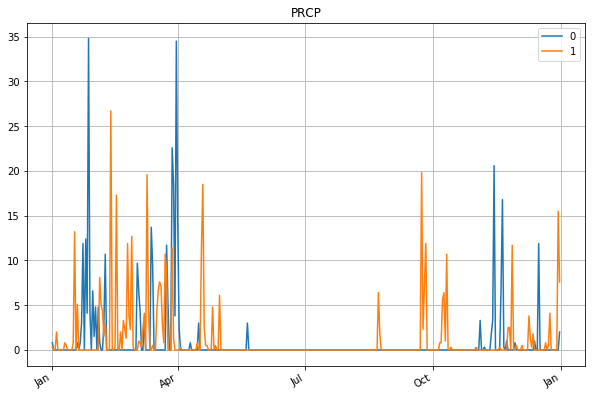

In [8]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')

In [10]:
0.3*30/2.54

3.543307086614173

In [11]:
df_SNWD = df_panda[df_panda['measurement']=='SNWD']

0.02333333333333333

In [12]:
0.75/30

0.025